# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
# Your code here:

sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [5]:
# Your code here:

sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
# Your code here:
sensor['date']=pd.date_range('1/1/2018 00:00:00','1/1/2018 00:29:10',periods=len(sensor))
sensor.date


0      2018-01-01 00:00:00
1      2018-01-01 00:00:01
2      2018-01-01 00:00:02
3      2018-01-01 00:00:03
4      2018-01-01 00:00:04
               ...        
1746   2018-01-01 00:29:06
1747   2018-01-01 00:29:07
1748   2018-01-01 00:29:08
1749   2018-01-01 00:29:09
1750   2018-01-01 00:29:10
Name: date, Length: 1751, dtype: datetime64[ns]

Assign the time series index to the dataframe's index.

In [7]:
# Your code here:

sensor.index = pd.DatetimeIndex(sensor.date,freq='S')
sensor.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', name='date', length=1751, freq='S')

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

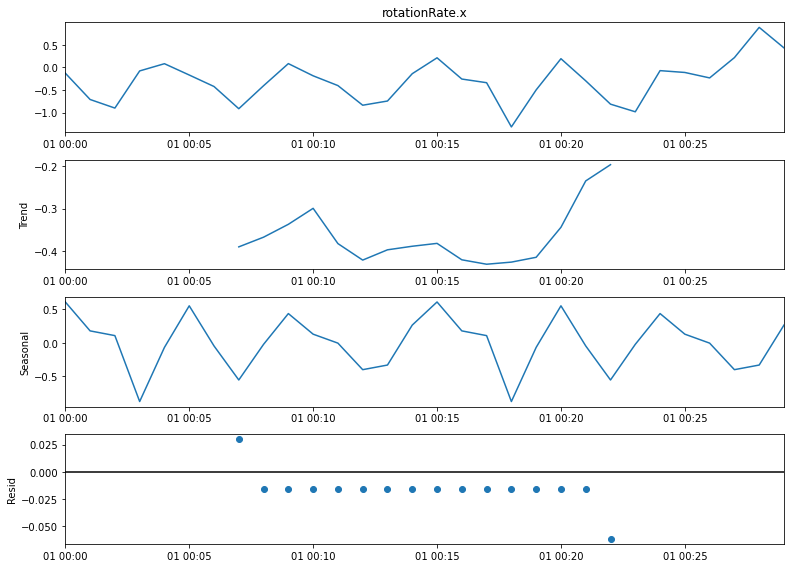

In [8]:
# Your code here:
y = sensor['rotationRate.x'].resample('1min').mean()

#Ajustes de tamaño de la figura
plt.rcParams['figure.figsize'] = 11,8
ts_rotation = sm.tsa.seasonal_decompose(y, model='additive', period=15)
figu = ts_rotation.plot()
plt.show()


Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

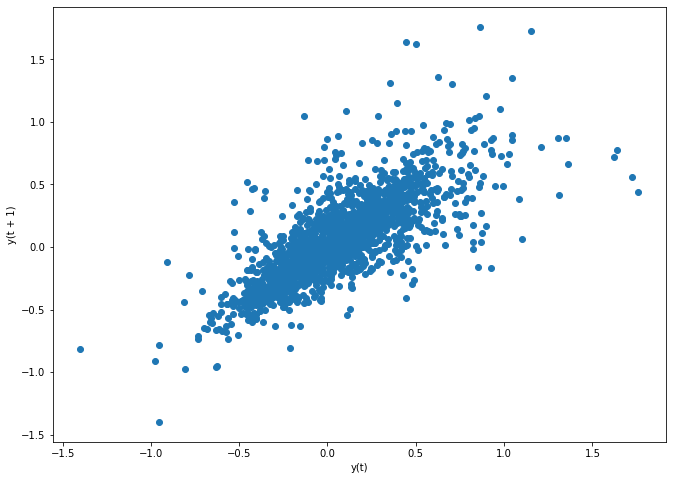

In [9]:
# Your code here:
lag_plot(sensor['userAcceleration.x'])


Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

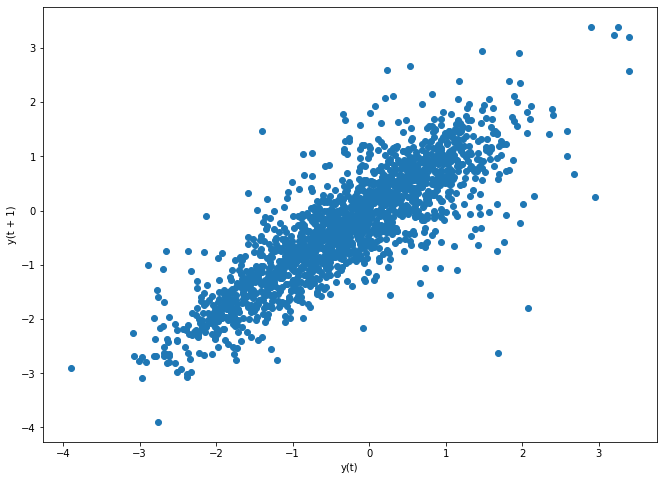

In [10]:
# Your code here:
lag_plot(sensor['rotationRate.x'])


What are your conclusions from both visualizations?

In [15]:
# Your conclusions here:
#se rechaza la hipotesis nula

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [17]:
# Your code here:

p_a = adfuller(sensor['userAcceleration.x'])[1]
p_r = adfuller(sensor['rotationRate.x'])[1]
print(p_a, p_r)

2.823439483037483e-30 6.320230335912249e-06


What are your conclusions from this test?

In [13]:
# Your conclusions here:

#en ambos casos el pvalue es menor a 0.05

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [16]:
# Your code here:

model = ARMA(sensor['userAcceleration.x'],order=(2,1))
model_fit = model.fit(disp=False)

# make predictions
predictions =  model_fit.predict(len(sensor)-10, len(sensor)-1)

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [18]:
# Your code here:
rmse(sensor['userAcceleration.x'][-10:],predictions)


0.09383216669267458

In [19]:
validation = pd.DataFrame({'observed':sensor['userAcceleration.x'][-10:], 'predicted':predictions})
validation

,observed,predicted
date,,
2018-01-01 00:29:01,0.149749,0.172776
2018-01-01 00:29:02,0.038461,0.115159
2018-01-01 00:29:03,-0.169175,-0.008270
2018-01-01 00:29:04,-0.300361,-0.186762
2018-01-01 00:29:05,-0.270174,-0.229211
2018-01-01 00:29:06,-0.268367,-0.136440
2018-01-01 00:29:07,-0.102444,-0.162658
2018-01-01 00:29:08,-0.085590,0.035719
2018-01-01 00:29:09,-0.048105,-0.043530


In [20]:
validation['dif'] = (validation.observed - validation.predicted)**2

In [21]:
rmse = np.sqrt(validation['dif'].sum()/len(validation))
rmse

0.09383216669267458